In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import socket, struct
import netaddr
from sklearn.cluster import KMeans



In [77]:
tp = pd.read_csv('capture20110818.pcap.netflow.labeled.csv', chunksize=1000)
df = pd.concat(tp, ignore_index=True)


#preprocessing
df = df[df['Label']!='Background']


ips = df['SrcIPAddr:Port'].str.split(':')
df['SrcIPAddr'] = ips.str[0]
df['SrcIPPort'] = ips.str[-1]
ips = df['DstIPAddr:Port'].str.split(':')
df['DstIPAddr'] = ips.str[0]
df['DstIPPort'] = ips.str[-1]

df = df.drop(['Date', 'Flow_start', 'tmp', 'Flows', 'SrcIPAddr:Port', 'DstIPAddr:Port'], axis=1)
df.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Label,Labels,SrcIPAddr,SrcIPPort,DstIPAddr,DstIPPort
20,4.985,TCP,PA_,0,91,86277,LEGITIMATE,NaN,147.32.80.13,80,147.32.85.88,56949
51,0.000,TCP,A_,0,1,66,LEGITIMATE,NaN,147.32.86.110,48102,74.125.232.214,443
57,4.921,TCP,A_,0,49,3234,LEGITIMATE,NaN,147.32.85.88,56949,147.32.80.13,80
73,4.742,TCP,A_,0,118,7080,LEGITIMATE,NaN,147.32.84.59,2768,74.125.108.208,80
75,0.000,TCP,A_,0,1,60,LEGITIMATE,NaN,147.32.84.59,56058,74.125.232.215,443


In [82]:
# malicious IP hosts 
# df[df['Label']=='Botnet']['SrcIPAddr'].value_counts()
# we are taking most frequent ones (also mentioned in README)
botnet_IPs = ['147.32.84.165', '147.32.84.209', '147.32.84.208']#, '147.32.84.207', '147.32.84.204', '147.32.84.206', 
#               '147.32.84.192', '147.32.84.191', '147.32.84.193', '147.32.84.205']
normal_IPs = ['147.32.84.170', '147.32.84.134']#, '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

df_dict = {}
for ip in botnet_IPs:
    df_dict[ip] = df[df['SrcIPAddr']==ip]
print(df_dict.keys())

df_dict_normal = {}
for ip in normal_IPs:
    df_dict_normal[ip] = df[df['SrcIPAddr']==ip]
print(df_dict_normal.keys())




dict_keys(['147.32.84.165', '147.32.84.209', '147.32.84.208'])
dict_keys(['147.32.84.170', '147.32.84.134'])


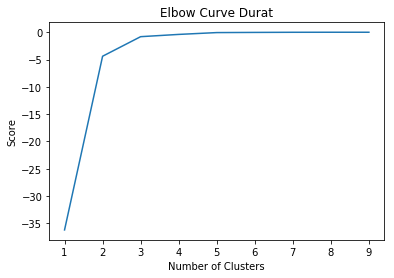

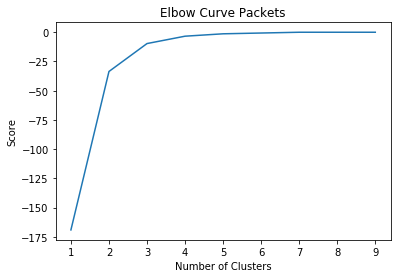

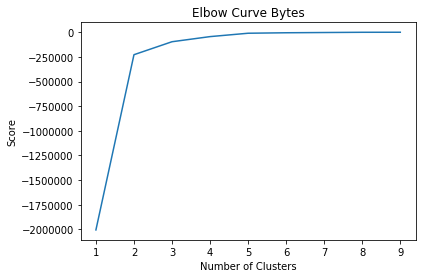

In [38]:
df = df[df['SrcIPAddr']=='147.32.84.165']

#clusters numerical
df_numerical = df[['Durat', 'Packets', 'Bytes']]
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
for column in df_numerical:
    X = df_numerical[column].values.reshape(-1, 1)
    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    plt.plot(Nc,score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve '+str(column))
    plt.show()

In [44]:
#elbow value identified from the above graphs
def get_elbows(df_numerical):
    elbow = {'Durat': 2, 'Packets': 3, 'Bytes': 3}
    for column in df_numerical:
        X = df_numerical[column].values.reshape(-1, 1)
        kmeans = KMeans(n_clusters=elbow[column], random_state=0).fit(X)
        df_numerical[column] = kmeans.labels_
    return df_numerical

get_elbows(df_numerical)
    
df_numerical.head()

,Durat,Packets,Bytes
299473,0,0,0
300156,0,0,0
300159,0,1,1
300735,0,0,0
300740,1,0,0


In [13]:
#clusters text
df_text = df[['Prot', 'Flags', 'Tos', 'SrcIPPort', 'DstIPAddr', 'DstIPPort']] 
for column in df_text:
    labels, levels = pd.factorize(df_text[column])
    df_text[column] = labels

df_text.head()

C:\Users\Anna\AppData\Local\Programs\Python\Python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Prot,Flags,Tos,SrcIPPort,DstIPAddr,DstIPPort
299473,0,0,0,0,0,0
300156,0,0,0,0,0,0
300159,1,1,0,1,1,1
300735,0,0,0,0,0,0
300740,0,0,0,2,2,2


In [14]:
df_discrete = pd.concat([df_text, df_numerical], axis=1)
df_discrete = df_discrete[['Prot','Bytes']]
code = 0
spaceSize = 1
for column in df_discrete:
    spaceSize = spaceSize * df_discrete[column].value_counts(dropna=True).count()

df_discrete.head()

,Prot,Bytes
299473,0,0
300156,0,0
300159,1,1
300735,0,0
300740,0,0


In [15]:

codes = np.array([])
spaceSizeCurrent = spaceSize
for index, row in df_discrete.iterrows():
    for column in df_discrete:
        if (row[column] >= 0):
            code  = code + (row[column] * spaceSizeCurrent / df_discrete[column].value_counts(dropna=True).count())
            spaceSizeCurrent =  spaceSizeCurrent / df_discrete[column].value_counts(dropna=True).count()

    codes = np.append(codes,code)
    spaceSizeCurrent = spaceSize
    code = 0


df_discrete['codes'] = codes
df = pd.concat([df_discrete,df[['SrcIPAddr','Label']]], axis=1)
df.head()

,Prot,Bytes,codes,SrcIPAddr,Label
299473,0,0,0.0,147.32.84.165,Botnet
300156,0,0,0.0,147.32.84.165,Botnet
300159,1,1,4.0,147.32.84.165,Botnet
300735,0,0,0.0,147.32.84.165,Botnet
300740,0,0,0.0,147.32.84.165,Botnet


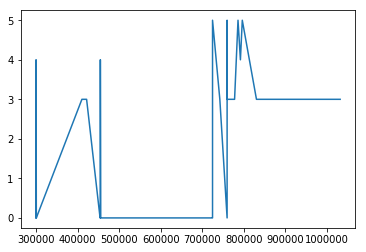

In [18]:
plt.plot(df['codes'])

In [45]:
def discretize(df):
    df_numerical = df[['Durat', 'Packets', 'Bytes']]
    df_numerical = get_elbows(df_numerical)
    df_text = df[['Prot', 'Flags', 'Tos', 'SrcIPPort', 'DstIPAddr', 'DstIPPort']] 
    for column in df_text:
        labels, levels = pd.factorize(df_text[column])
        df_text[column] = labels

    df_discrete = pd.concat([df_text, df_numerical], axis=1)
    df_discrete = df_discrete[['Prot','Bytes']]
    code = 0
    spaceSize = 1
    for column in df_discrete:
        spaceSize = spaceSize * df_discrete[column].value_counts(dropna=True).count()

    codes = np.array([])
    spaceSizeCurrent = spaceSize
    for index, row in df_discrete.iterrows():
        for column in df_discrete:
            if (row[column] >= 0):
                code  = code + (row[column] * spaceSizeCurrent / df_discrete[column].value_counts(dropna=True).count())
                spaceSizeCurrent =  spaceSizeCurrent / df_discrete[column].value_counts(dropna=True).count()

        codes = np.append(codes,code)
        spaceSizeCurrent = spaceSize
        code = 0


    df_discrete['codes'] = codes
    df = pd.concat([df_discrete,df[['SrcIPAddr','Label']]], axis=1)
    return df

In [83]:
discret_df = {}
for key, value in df_dict.items():
    discret_df[key] = discretize(value)
    
discret_df_normal = {}
for key, value in df_dict_normal.items():
    discret_df_normal[key] = discretize(value)

C:\Users\Anna\AppData\Local\Programs\Python\Python36-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [72]:
def n_gram_model(n_grams):
    model = dict.fromkeys(n_grams)

    for i in range(len(n_grams)-1):
        if model[n_grams[i]] is None:
            model[n_grams[i]] = {}
        if n_grams[i+1] not in model[n_grams[i]]:
            model[n_grams[i]][n_grams[i+1]] = 0
        model[n_grams[i]][n_grams[i + 1]] += 1

    for key in model:
        if model[key] is None:
            continue
        total_count = float(sum(model[key].values()))
        for w2 in model[key]:
            model[key][w2] /= total_count

    return model

def n_gram_predict(model, n_grams, threshold):
    probalilites = []
    true_prob = []
    for i in range(len(n_grams)-1):
        if n_grams[i] not in model or n_grams[i+1] not in model[n_grams[i]]:
            prob = 0
        else:
            prob = model[n_grams[i]][n_grams[i+1]]
        if prob > threshold:
            true_prob.append(prob)
            probalilites.append(1)
        else:
            probalilites.append(0)
#     print(true_prob)
    return np.array(probalilites).transpose()

In [73]:
model = n_gram_model(discret_df[botnet_IPs[0]]['codes'].values)
print(model)

{0.0: {0.0: 0.5454545454545454, 4.0: 0.2727272727272727, 3.0: 0.09090909090909091, 5.0: 0.09090909090909091}, 4.0: {0.0: 0.5, 5.0: 0.5}, 3.0: {3.0: 0.9696969696969697, 0.0: 0.020202020202020204, 5.0: 0.010101010101010102}, 5.0: {3.0: 0.75, 4.0: 0.25}}


In [90]:
test_model = discret_df[botnet_IPs[1]]['codes'].values
prob = n_gram_predict(model, test_model, 0.4)
prob

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1])

In [92]:
test_model = discret_df_normal[normal_IPs[1]]['codes'].values
prob = n_gram_predict(model, test_model, 0.4)
print(len(prob))
print(sum(prob==1))

754
664
